In [30]:
import io
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms

import os
# Set custom cache directory
os.environ["TRANSFORMERS_CACHE"] = "/mnt/bd/pipo-compliance-aml/cache"

from vit import ViT

In [31]:
import torch

# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")


Using device: cuda


In [32]:
seed = 2025
# Training settings
batch_size = 128
epochs = 20
lr = 3e-5
gamma = 0.7

In [33]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [34]:


ds = load_dataset("Bingsu/Cat_and_Dog")
# Set the format to "torch" (for all columns)
# ds.set_format(type='torch', columns=['image', 'labels'])

Generating train split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [36]:
train, test = ds['train'], ds['test']

# Split the training set into 80% train and 20% test
split_dataset = train.train_test_split(test_size=0.2)
# Access the new train and test splits
train = split_dataset["train"]
val =  split_dataset["test"]

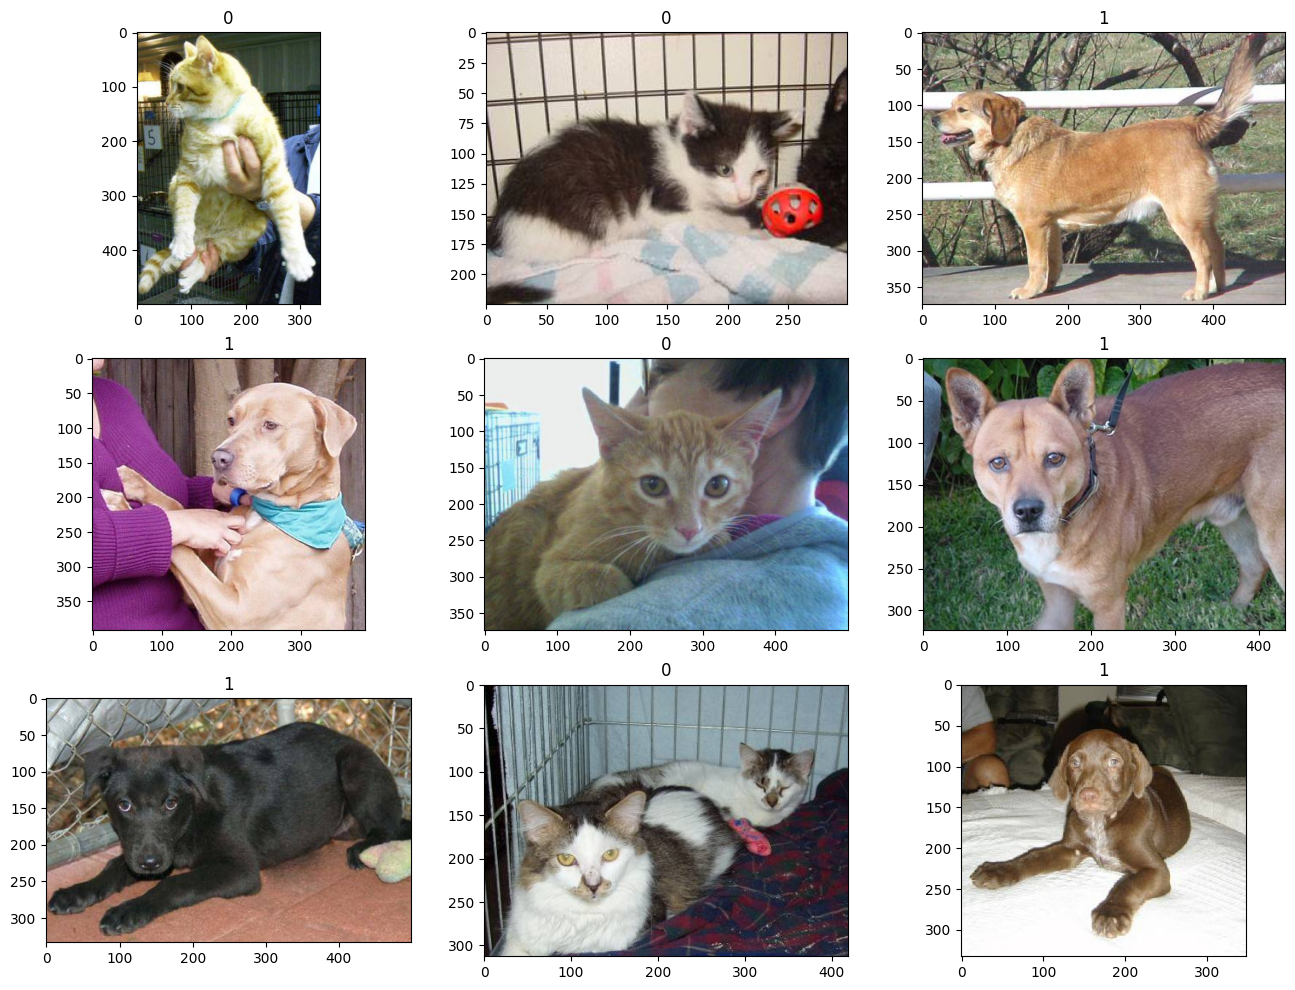

In [37]:
random_idx = np.random.randint(1, len(train), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    # Example raw image data (from a file or other source)
    img = train[int(random_idx[idx])]['image']
    ax.set_title(train[int(random_idx[idx])]['labels'])
    ax.imshow(img)

In [11]:
# np.array(test[0]['image']).shape

# Image Augmentation

In [38]:
_train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

_val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


_test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


def train_transforms(example):
    example['pixel_values'] = _train_transforms(example['image'])
    return example

def val_transforms(example):
    example['pixel_values'] = _val_transforms(example['image'])
    return example

def test_transforms(example):
    example['pixel_values'] = _test_transforms(example['image'])
    return example

train = train.map(train_transforms)
val =  val.map(train_transforms)
# test =  test.map(train_transforms)


Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [ ]:
# Set the format to 'torch' to automatically convert data to tensors
train.set_format("torch")
val.set_format("torch")
test.set_format("torch")

train = train.remove_columns(["image"])
val = val.remove_columns(["image"])
test = test.remove_columns(["image"])

# def collate_fn(example):
#     pixel_values = torch.stack(example["pixel_values"])
#     labels = torch.tensor(example["labels"])
#     return {"pixel_values": pixel_values, "labels": labels}

train_loader = DataLoader(dataset = train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test, batch_size=batch_size, shuffle=True)

In [41]:
for batch in train_loader:
    batch
    # data = torch.tensor(np.array(batch['image']),  dtype=torch.float32).to(device)
    print(batch['pixel_values'].shape)
    break

torch.Size([128, 3, 224, 224])


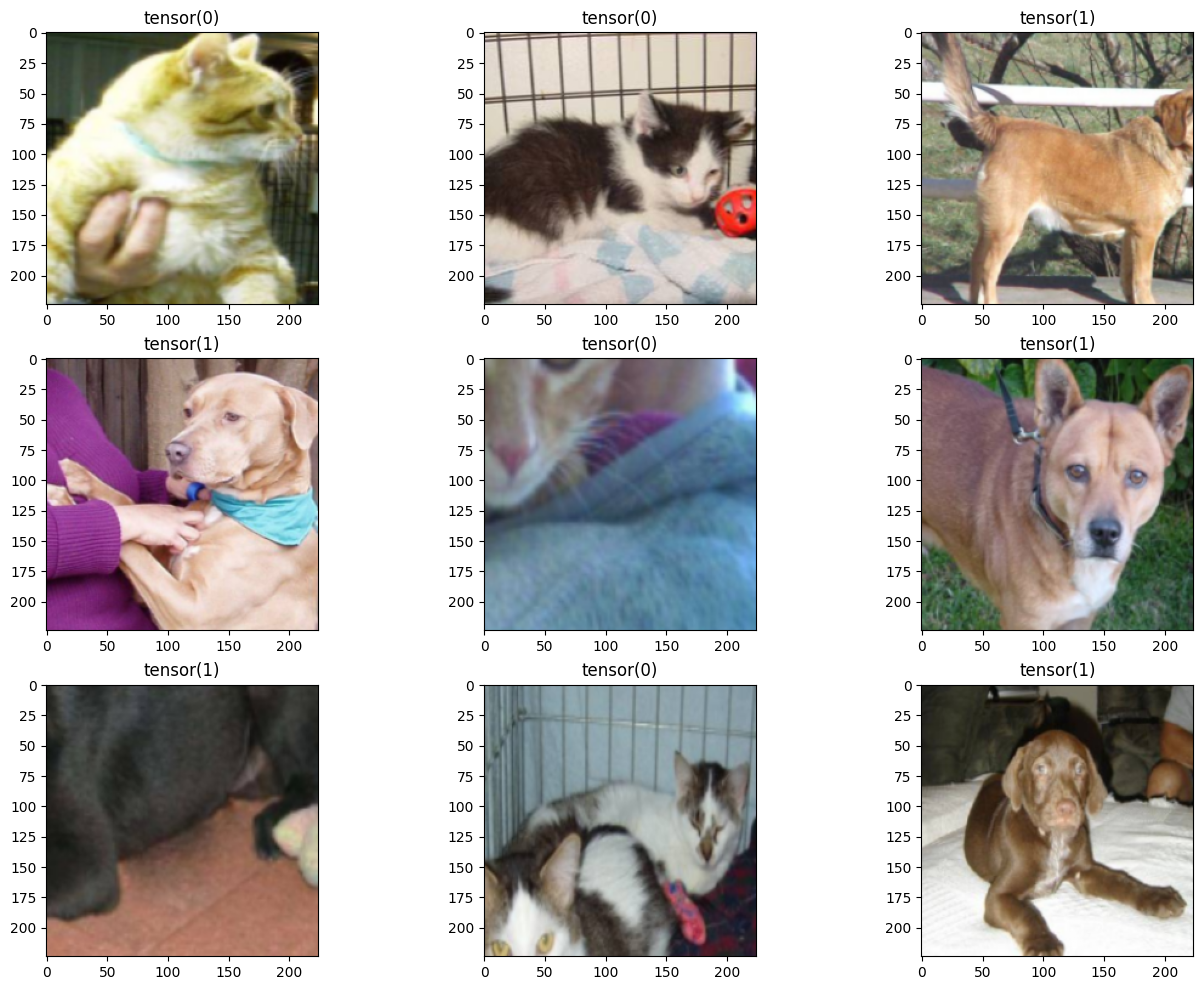

In [42]:
# random_idx = np.random.randint(1, len(train), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    # Example raw image data (from a file or other source)
    img = train[int(random_idx[idx])]['pixel_values']
    img = np.array(img).transpose(1, 2, 0)
    # img = Image.open(img)
    ax.set_title(train[int(random_idx[idx])]['labels'])
    ax.imshow(img)

In [46]:
model = ViT(
    image_size = 224,
    patch_size = 32,
    num_classes = 2,
    dim = 256,
    depth = 6,
    heads = 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

In [47]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for batch in tqdm(train_loader):
        data = torch.tensor(np.array(batch['pixel_values']),  dtype=torch.float32).to(device)
        label = torch.tensor(batch['labels'],  dtype=torch.long).to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for batch in tqdm(valid_loader):
            data = batch['pixel_values'].to(device)
            label = batch['labels'].to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
   
    with open('/mnt/bd/pipo-compliance-aml/learn-llm-from-scratch/source-code/vit/loss.txt', "a") as f:  # "a" mode appends to the file
        loss = f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        print(loss)
        f.write(loss)

  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_1917/1953599799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(batch['labels'],  dtype=torch.long).to(device)


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6866 - acc: 0.5509 - val_loss : 0.6782 - val_acc: 0.5655



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6761 - acc: 0.5697 - val_loss : 0.6988 - val_acc: 0.5439



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6735 - acc: 0.5783 - val_loss : 0.6710 - val_acc: 0.5667



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6543 - acc: 0.6017 - val_loss : 0.6756 - val_acc: 0.5715



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6436 - acc: 0.6130 - val_loss : 0.6599 - val_acc: 0.6010



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6343 - acc: 0.6334 - val_loss : 0.6660 - val_acc: 0.5925



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6231 - acc: 0.6414 - val_loss : 0.6480 - val_acc: 0.6244



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.5777 - acc: 0.6852 - val_loss : 0.6499 - val_acc: 0.6328



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.5583 - acc: 0.7084 - val_loss : 0.6572 - val_acc: 0.6322



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]